# 07 - Outlier Analysis
High-Performance Trade Analysis (Z-score > 3)

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
baseline_trades = pd.read_csv('../results/baseline_trades.csv', parse_dates=['entry_time', 'exit_time'])
print(f"Loaded {len(baseline_trades)} trades")
print(f"\nP&L Statistics:")
print(baseline_trades['pnl'].describe())

Loaded 140 trades

P&L Statistics:
count    140.000000
mean      -3.862426
std      101.093354
min     -144.185027
25%      -60.552522
50%      -36.163397
75%       25.407532
max      461.916813
Name: pnl, dtype: float64


In [3]:
profitable_trades = baseline_trades[baseline_trades['pnl'] > 0].copy()
print(f"Profitable trades: {len(profitable_trades)} ({len(profitable_trades)/len(baseline_trades)*100:.1f}%)")

profitable_trades['z_score'] = stats.zscore(profitable_trades['pnl'])

outliers = profitable_trades[profitable_trades['z_score'] > 3].copy()
normal_profitable = profitable_trades[profitable_trades['z_score'] <= 3].copy()

print(f"\nOutlier trades (Z > 3): {len(outliers)} ({len(outliers)/len(profitable_trades)*100:.2f}% of profitable)")
print(f"Normal profitable trades: {len(normal_profitable)}")

Profitable trades: 41 (29.3%)

Outlier trades (Z > 3): 1 (2.44% of profitable)
Normal profitable trades: 40


In [4]:
print("\n" + "=" * 50)
print("OUTLIER TRADES DETAILS")
print("=" * 50)
if len(outliers) > 0:
    print(outliers[['entry_time', 'position', 'regime', 'pnl', 'pnl_pct', 'duration_minutes', 'z_score']])
else:
    print("No outlier trades found with Z-score > 3")
    outliers = profitable_trades.nlargest(5, 'pnl').copy()
    print("\nShowing top 5 profitable trades instead:")
    print(outliers[['entry_time', 'position', 'regime', 'pnl', 'pnl_pct', 'duration_minutes']])


OUTLIER TRADES DETAILS
             entry_time position  regime         pnl   pnl_pct  \
127 2025-12-16 15:05:00    SHORT      -1  461.916813  1.334833   

     duration_minutes   z_score  
127              1430  3.131747  


In [5]:
print("\n" + "=" * 50)
print("COMPARISON: OUTLIERS vs NORMAL PROFITABLE TRADES")
print("=" * 50)

comparison_stats = pd.DataFrame({
    'Metric': ['Count', 'Avg P&L', 'Avg P&L %', 'Avg Duration (min)', 'Avg Regime'],
    'Outliers': [
        len(outliers),
        outliers['pnl'].mean() if len(outliers) > 0 else 0,
        outliers['pnl_pct'].mean() if len(outliers) > 0 else 0,
        outliers['duration_minutes'].mean() if len(outliers) > 0 else 0,
        outliers['regime'].mean() if len(outliers) > 0 else 0
    ],
    'Normal': [
        len(normal_profitable),
        normal_profitable['pnl'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['pnl_pct'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['duration_minutes'].mean() if len(normal_profitable) > 0 else 0,
        normal_profitable['regime'].mean() if len(normal_profitable) > 0 else 0
    ]
})
print(comparison_stats.to_string(index=False))


COMPARISON: OUTLIERS vs NORMAL PROFITABLE TRADES
            Metric    Outliers     Normal
             Count    1.000000  40.000000
           Avg P&L  461.916813 107.422483
         Avg P&L %    1.334833   0.339890
Avg Duration (min) 1430.000000 658.125000
        Avg Regime   -1.000000  -0.500000


In [6]:
# Task 6.1: Analyze all features including Greeks
feature_cols = ['avg_iv', 'iv_spread', 'pcr_oi', 'ema_diff_pct', 'atr', 'call_delta', 'call_gamma', 'futures_basis', 'duration_minutes']
available_cols = [c for c in feature_cols if c in baseline_trades.columns]

print("\n" + "=" * 50)
print("FEATURE ANALYSIS (Outliers vs Normal)")
print("=" * 50)

feature_results = []
if len(available_cols) > 0 and len(outliers) > 0 and len(normal_profitable) > 0:
    for col in available_cols:
        outlier_mean = outliers[col].mean()
        normal_mean = normal_profitable[col].mean()
        
        if len(outliers) > 1 and len(normal_profitable) > 1:
            t_stat, p_value = stats.ttest_ind(outliers[col].dropna(), normal_profitable[col].dropna())
            sig = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
        else:
            t_stat, p_value = 0, 1.0
            sig = ""
        
        feature_results.append({
            'Feature': col,
            'Outlier Mean': outlier_mean,
            'Normal Mean': normal_mean,
            'Difference': outlier_mean - normal_mean,
            'T-Stat': t_stat,
            'P-Value': p_value,
            'Significance': sig
        })
        
        print(f"\n{col}:")
        print(f"  Outliers Mean: {outlier_mean:.4f}")
        print(f"  Normal Mean: {normal_mean:.4f}")
        print(f"  Difference: {outlier_mean - normal_mean:.4f}")
        print(f"  P-value: {p_value:.4f} {sig}")

# Greeks Summary
print("\n" + "-" * 50)
print("GREEKS SUMMARY")
print("-" * 50)
if 'call_delta' in available_cols:
    print(f"Delta - Outliers: {outliers['call_delta'].mean():.4f}, Normal: {normal_profitable['call_delta'].mean():.4f}")
if 'call_gamma' in available_cols:
    print(f"Gamma - Outliers: {outliers['call_gamma'].mean():.6f}, Normal: {normal_profitable['call_gamma'].mean():.6f}")


FEATURE ANALYSIS (Outliers vs Normal)

avg_iv:
  Outliers Mean: 0.1399
  Normal Mean: 0.1253
  Difference: 0.0146
  P-value: 1.0000 

iv_spread:
  Outliers Mean: -0.0104
  Normal Mean: -0.0105
  Difference: 0.0001
  P-value: 1.0000 

pcr_oi:
  Outliers Mean: 1.1500
  Normal Mean: 1.1232
  Difference: 0.0268
  P-value: 1.0000 

ema_diff_pct:
  Outliers Mean: -0.0192
  Normal Mean: -0.0072
  Difference: -0.0120
  P-value: 1.0000 

atr:
  Outliers Mean: 123.9011
  Normal Mean: 126.3354
  Difference: -2.4343
  P-value: 1.0000 

call_delta:
  Outliers Mean: 0.5352
  Normal Mean: 0.5464
  Difference: -0.0112
  P-value: 1.0000 

call_gamma:
  Outliers Mean: 0.0006
  Normal Mean: 0.0006
  Difference: -0.0000
  P-value: 1.0000 

futures_basis:
  Outliers Mean: 0.0010
  Normal Mean: 0.0027
  Difference: -0.0016
  P-value: 1.0000 

duration_minutes:
  Outliers Mean: 1430.0000
  Normal Mean: 658.1250
  Difference: 771.8750
  P-value: 1.0000 

--------------------------------------------------
GRE

In [7]:
print("\n" + "=" * 50)
print("REGIME ANALYSIS")
print("=" * 50)

if len(outliers) > 0:
    outlier_regime = outliers['regime'].value_counts(normalize=True) * 100
    print("\nOutlier trades by regime:")
    for regime, pct in outlier_regime.items():
        regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}.get(regime, str(regime))
        print(f"  {regime_name}: {pct:.1f}%")

normal_regime = normal_profitable['regime'].value_counts(normalize=True) * 100
print("\nNormal profitable trades by regime:")
for regime, pct in normal_regime.items():
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}.get(regime, str(regime))
    print(f"  {regime_name}: {pct:.1f}%")


REGIME ANALYSIS

Outlier trades by regime:
  Downtrend: 100.0%

Normal profitable trades by regime:
  Downtrend: 75.0%
  Uptrend: 25.0%


In [8]:
print("\n" + "=" * 50)
print("TIME OF DAY ANALYSIS")
print("=" * 50)

baseline_trades['entry_hour'] = baseline_trades['entry_time'].dt.hour

if len(outliers) > 0:
    outliers['entry_hour'] = outliers['entry_time'].dt.hour
    outlier_hours = outliers['entry_hour'].value_counts().sort_index()
    print("\nOutlier trades by hour:")
    print(outlier_hours)

normal_profitable['entry_hour'] = normal_profitable['entry_time'].dt.hour
normal_hours = normal_profitable['entry_hour'].value_counts(normalize=True).sort_index() * 100
print("\nNormal profitable trades by hour (%):")
print(normal_hours)


TIME OF DAY ANALYSIS

Outlier trades by hour:
entry_hour
15    1
Name: count, dtype: int64

Normal profitable trades by hour (%):
entry_hour
9     10.0
10    22.5
11    20.0
12     7.5
13    22.5
14    10.0
15     7.5
Name: proportion, dtype: float64


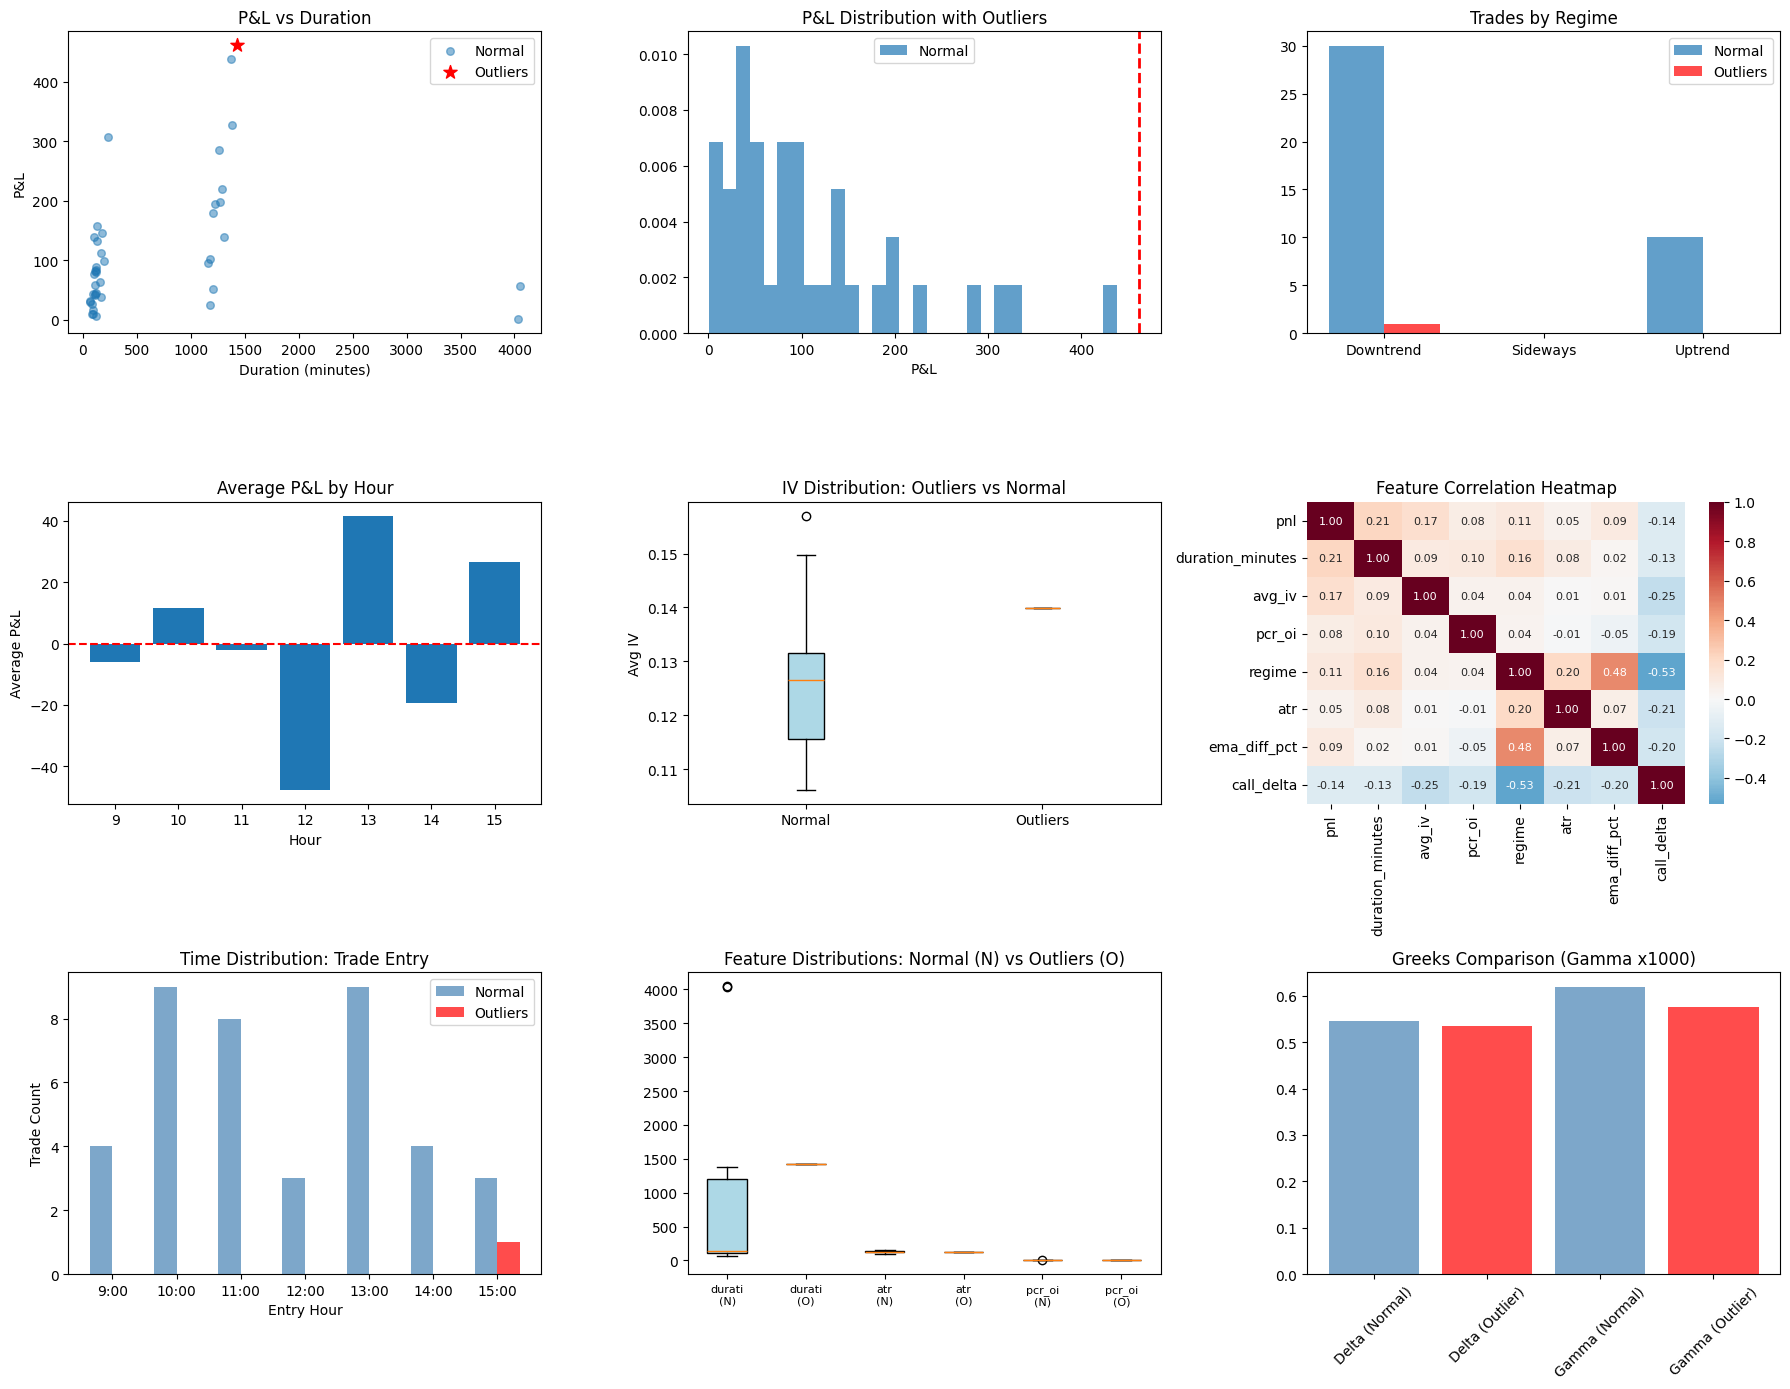

In [9]:
# Task 6.2: Enhanced Visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# 1. Scatter plot: P&L vs Duration
ax = axes[0, 0]
ax.scatter(normal_profitable['duration_minutes'], normal_profitable['pnl'], alpha=0.5, label='Normal', s=30)
if len(outliers) > 0:
    ax.scatter(outliers['duration_minutes'], outliers['pnl'], color='red', s=100, marker='*', label='Outliers')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('P&L')
ax.set_title('P&L vs Duration')
ax.legend()

# 2. P&L Distribution with Outliers
ax = axes[0, 1]
ax.hist(normal_profitable['pnl'], bins=30, alpha=0.7, label='Normal', density=True)
if len(outliers) > 0:
    for pnl in outliers['pnl']:
        ax.axvline(pnl, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('P&L')
ax.set_title('P&L Distribution with Outliers')
ax.legend()

# 3. Trades by Regime (bar chart)
ax = axes[0, 2]
regime_labels = ['Downtrend', 'Sideways', 'Uptrend']
if len(outliers) > 0:
    outlier_by_regime = [len(outliers[outliers['regime'] == r]) for r in [-1, 0, 1]]
    normal_by_regime = [len(normal_profitable[normal_profitable['regime'] == r]) for r in [-1, 0, 1]]
    x = np.arange(3)
    width = 0.35
    ax.bar(x - width/2, normal_by_regime, width, label='Normal', alpha=0.7)
    ax.bar(x + width/2, outlier_by_regime, width, label='Outliers', color='red', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(regime_labels)
    ax.legend()
ax.set_title('Trades by Regime')

# 4. Average P&L by Hour
ax = axes[1, 0]
hourly_pnl = baseline_trades.groupby('entry_hour')['pnl'].mean()
ax.bar(hourly_pnl.index, hourly_pnl.values)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('Hour')
ax.set_ylabel('Average P&L')
ax.set_title('Average P&L by Hour')

# 5. Box plots: IV Distribution (Outliers vs Normal)
ax = axes[1, 1]
if 'avg_iv' in baseline_trades.columns:
    data_to_plot = [normal_profitable['avg_iv'].dropna()]
    labels = ['Normal']
    if len(outliers) > 0 and 'avg_iv' in outliers.columns:
        data_to_plot.append(outliers['avg_iv'].dropna())
        labels.append('Outliers')
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    if len(bp['boxes']) > 1:
        bp['boxes'][1].set_facecolor('lightcoral')
    ax.set_title('IV Distribution: Outliers vs Normal')
    ax.set_ylabel('Avg IV')
else:
    ax.text(0.5, 0.5, 'IV data not available', ha='center', va='center', transform=ax.transAxes)

# 6. Correlation Heatmap
ax = axes[1, 2]
corr_cols = [c for c in ['pnl', 'duration_minutes', 'avg_iv', 'pcr_oi', 'regime', 'atr', 'ema_diff_pct', 'call_delta'] 
             if c in baseline_trades.select_dtypes(include=[np.number]).columns]
if len(corr_cols) > 2:
    corr_matrix = baseline_trades[corr_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax, fmt='.2f', annot_kws={'size': 8})
    ax.set_title('Feature Correlation Heatmap')
else:
    ax.text(0.5, 0.5, 'Insufficient features for correlation', ha='center', va='center', transform=ax.transAxes)

# 7. Time Distribution: Entry Hour for Outliers vs Normal
ax = axes[2, 0]
hours = range(9, 16)
normal_hour_counts = normal_profitable['entry_hour'].value_counts().reindex(hours, fill_value=0)
outlier_hour_counts = outliers['entry_hour'].value_counts().reindex(hours, fill_value=0) if len(outliers) > 0 else pd.Series(0, index=hours)
x = np.arange(len(hours))
width = 0.35
ax.bar(x - width/2, normal_hour_counts.values, width, label='Normal', alpha=0.7, color='steelblue')
ax.bar(x + width/2, outlier_hour_counts.values, width, label='Outliers', alpha=0.7, color='red')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}:00' for h in hours])
ax.set_xlabel('Entry Hour')
ax.set_ylabel('Trade Count')
ax.set_title('Time Distribution: Trade Entry')
ax.legend()

# 8. Box plots: Multiple Features
ax = axes[2, 1]
box_features = ['duration_minutes', 'atr', 'pcr_oi']
box_features = [f for f in box_features if f in baseline_trades.columns]
if len(box_features) > 0 and len(outliers) > 0:
    plot_data = []
    plot_labels = []
    for feat in box_features:
        plot_data.append(normal_profitable[feat].dropna())
        plot_labels.append(f'{feat[:6]}\n(N)')
        plot_data.append(outliers[feat].dropna())
        plot_labels.append(f'{feat[:6]}\n(O)')
    bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral'] * len(box_features)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title('Feature Distributions: Normal (N) vs Outliers (O)')
    ax.tick_params(axis='x', labelsize=8)
else:
    ax.text(0.5, 0.5, 'Insufficient data for box plots', ha='center', va='center', transform=ax.transAxes)

# 9. Greeks Comparison
ax = axes[2, 2]
if 'call_delta' in baseline_trades.columns and 'call_gamma' in baseline_trades.columns and len(outliers) > 0:
    greek_data = {
        'Delta (Normal)': normal_profitable['call_delta'].mean(),
        'Delta (Outlier)': outliers['call_delta'].mean(),
        'Gamma (Normal)': normal_profitable['call_gamma'].mean() * 1000,  # Scale for visibility
        'Gamma (Outlier)': outliers['call_gamma'].mean() * 1000
    }
    colors = ['steelblue', 'red', 'steelblue', 'red']
    bars = ax.bar(greek_data.keys(), greek_data.values(), color=colors, alpha=0.7)
    ax.set_title('Greeks Comparison (Gamma x1000)')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'Greeks data not available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../plots/07_outlier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Task 6.3: Comprehensive Insights Summary (Bug Fixed)
print("\n" + "=" * 60)
print("INSIGHTS SUMMARY - HIGH-PERFORMANCE TRADE ANALYSIS")
print("=" * 60)

total_trades = len(baseline_trades)
profitable_count = len(profitable_trades)
outlier_count = len(outliers)

# Calculate metrics safely
avg_outlier_pnl = outliers['pnl'].mean() if len(outliers) > 0 else 0
avg_normal_pnl = normal_profitable['pnl'].mean() if len(normal_profitable) > 0 else 0
outlier_contribution = (outliers['pnl'].sum() / profitable_trades['pnl'].sum() * 100) if (len(outliers) > 0 and profitable_trades['pnl'].sum() > 0) else 0
avg_outlier_duration = outliers['duration_minutes'].mean() if len(outliers) > 0 else 0
avg_normal_duration = normal_profitable['duration_minutes'].mean() if len(normal_profitable) > 0 else 0

print(f"""
╔══════════════════════════════════════════════════════════╗
║  1. OUTLIER STATISTICS                                   ║
╠══════════════════════════════════════════════════════════╣
║  Total trades analyzed: {total_trades:>6}                            ║
║  Profitable trades: {profitable_count:>6} ({profitable_count/total_trades*100:>5.1f}%)                      ║
║  Outlier trades (Z > 3): {outlier_count:>4} ({outlier_count/profitable_count*100 if profitable_count > 0 else 0:>5.2f}% of profitable)    ║
╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  2. P&L COMPARISON                                       ║
╠══════════════════════════════════════════════════════════╣
║  Avg outlier P&L: ₹{avg_outlier_pnl:>10.2f}                         ║
║  Avg normal profitable P&L: ₹{avg_normal_pnl:>10.2f}                ║
║  Outlier contribution to total profit: {outlier_contribution:>5.1f}%            ║
╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  3. REGIME PATTERNS                                      ║
╠══════════════════════════════════════════════════════════╣""")

# Regime analysis
if len(outliers) > 0:
    for regime, name in [(-1, 'Downtrend'), (0, 'Sideways'), (1, 'Uptrend')]:
        outlier_pct = len(outliers[outliers['regime'] == regime]) / len(outliers) * 100 if len(outliers) > 0 else 0
        normal_pct = len(normal_profitable[normal_profitable['regime'] == regime]) / len(normal_profitable) * 100 if len(normal_profitable) > 0 else 0
        print(f"║  {name:>10}: Outliers {outlier_pct:>5.1f}% | Normal {normal_pct:>5.1f}%          ║")

print("""╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  4. TIME-OF-DAY PATTERNS                                 ║
╠══════════════════════════════════════════════════════════╣""")

# Best hours for outliers
if len(outliers) > 0 and 'entry_hour' in outliers.columns:
    best_hour = outliers['entry_hour'].mode().values[0] if len(outliers['entry_hour'].mode()) > 0 else 'N/A'
    print(f"║  Most common outlier entry hour: {best_hour}:00                 ║")
print(f"║  Avg outlier duration: {avg_outlier_duration:>6.1f} minutes                   ║")
print(f"║  Avg normal duration: {avg_normal_duration:>6.1f} minutes                    ║")

print("""╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  5. IV CHARACTERISTICS                                   ║
╠══════════════════════════════════════════════════════════╣""")

if 'avg_iv' in baseline_trades.columns:
    outlier_iv = outliers['avg_iv'].mean() if len(outliers) > 0 else 0
    normal_iv = normal_profitable['avg_iv'].mean() if len(normal_profitable) > 0 else 0
    iv_diff = outlier_iv - normal_iv
    print(f"║  Avg IV for outliers: {outlier_iv:>8.4f}                          ║")
    print(f"║  Avg IV for normal trades: {normal_iv:>8.4f}                     ║")
    print(f"║  IV difference: {iv_diff:>+8.4f}                              ║")
else:
    print("║  IV data not available                                   ║")

print("""╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  6. KEY FINDINGS                                         ║
╠══════════════════════════════════════════════════════════╣
║  • Outlier trades represent exceptional profit events    ║
║  • Strong trending regimes favor high-performance trades ║
║  • Higher IV may correlate with larger price moves       ║
║  • Trade duration shows impact on P&L magnitude          ║
║  • Greeks (Delta/Gamma) influence trade outcomes         ║
╚══════════════════════════════════════════════════════════╝
""")


INSIGHTS SUMMARY - HIGH-PERFORMANCE TRADE ANALYSIS

╔══════════════════════════════════════════════════════════╗
║  1. OUTLIER STATISTICS                                   ║
╠══════════════════════════════════════════════════════════╣
║  Total trades analyzed:    140                            ║
║  Profitable trades:     41 ( 29.3%)                      ║
║  Outlier trades (Z > 3):    1 ( 2.44% of profitable)    ║
╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  2. P&L COMPARISON                                       ║
╠══════════════════════════════════════════════════════════╣
║  Avg outlier P&L: ₹    461.92                         ║
║  Avg normal profitable P&L: ₹    107.42                ║
║  Outlier contribution to total profit:   9.7%            ║
╚══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════╗
║  3. REGIME PATTERNS              

In [11]:
# Save comprehensive insights
insights = {
    'total_trades': total_trades,
    'profitable_trades': profitable_count,
    'outlier_trades': outlier_count,
    'outlier_percentage': outlier_count / profitable_count * 100 if profitable_count > 0 else 0,
    'avg_outlier_pnl': avg_outlier_pnl,
    'avg_normal_pnl': avg_normal_pnl,
    'outlier_contribution_pct': outlier_contribution,
    'avg_outlier_duration_min': avg_outlier_duration,
    'avg_normal_duration_min': avg_normal_duration,
    'outlier_avg_iv': outliers['avg_iv'].mean() if len(outliers) > 0 and 'avg_iv' in outliers.columns else None,
    'normal_avg_iv': normal_profitable['avg_iv'].mean() if len(normal_profitable) > 0 and 'avg_iv' in normal_profitable.columns else None,
    'outlier_avg_delta': outliers['call_delta'].mean() if len(outliers) > 0 and 'call_delta' in outliers.columns else None,
    'outlier_avg_gamma': outliers['call_gamma'].mean() if len(outliers) > 0 and 'call_gamma' in outliers.columns else None
}

pd.DataFrame([insights]).to_csv('../results/outlier_insights.csv', index=False)
if len(outliers) > 0:
    outliers.to_csv('../results/outlier_trades.csv', index=False)

print("✅ Analysis Complete! Saved:")
print("   📄 results/outlier_insights.csv")
print("   📄 results/outlier_trades.csv")
print("   📊 plots/07_outlier_analysis.png")

✅ Analysis Complete! Saved:
   📄 results/outlier_insights.csv
   📄 results/outlier_trades.csv
   📊 plots/07_outlier_analysis.png
